# Pixels Don’t Lie: Unmasking Rizal-Jack the Ripper Hoax Through Computer Vision

A Partial Requirement in PI 100

Developed by: Erru Torculas & Michael Vincent Dosado

***

# HYBRID IMAGE PREPROCESSING

## Importing Libraries

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Cross Correlation

Given a kernel of arbitrary m x n dimensions, with both m and n being odd, compute the cross correlation of the given image with the given kernel, such that the output is of the same dimensions as the image and that you assume the pixels out of the bounds of the image to be zero. Note thatyou need to apply the kernel to each channel separately, if the given image is an RGB image.

    Inputs:
        img:    Either an RGB image (height x width x 3) or a grayscale image
                (height x width) as a numpy array.
        kernel: A 2D numpy array (m x n), with m and n both odd (but may not be
                equal).

    Output:
        Return an image of the same dimensions as the input image (same width,
        height and the number of color channels)

In [2]:
def cross_correlation_2d(img, kernel):
    # rotating kernel with 180 degrees
    kernel = np.flip(kernel)
    
    # shape attribute to aggregate the height and width easily
    kernel_height, kernel_width = kernel.shape

    # make sure that the scale of kernel is odd
    if (kernel_height % 2 == 0) or (kernel_width % 2 == 0):
        raise ValueError('Make sure that the scale of kernel is odd')   # Returns a ValueError when the kernel's scale is odd

    # the scale of result
    conv_height = img.shape[0] - kernel_height + 1
    conv_width = img.shape[1] - kernel_width + 1
    conv = np.zeros((conv_height, conv_width))

    # convolve
    for i in range(conv_height):
        for j in range(conv_width):
            result = np.sum(img[i:i + kernel_height, j:j + kernel_width] * kernel)      # np.sum would make the calculations faster
            result = np.clip(result, 0, 255)                                            # used the np.clip instead of if conditions
            conv[i, j] = result

    return conv

## Convolution

Use cross_correlation_2d() to carry out a 2D convolution.

    Inputs:
        img:    Either an RGB image (height x width x 3) or a grayscale image
                (height x width) as a numpy array.
        kernel: A 2D numpy array (m x n), with m and n both odd (but may not be
                equal).

    Output:
        Return an image of the same dimensions as the input image (same width,
        height and the number of color channels)

In [3]:
def convolve_2d(img, kernel):
    # Function  to pad the input image
    def imagePadded(img, kernel):
        kernel_width, kernel_height = kernel.shape
        pad_h = kernel_width // 2
        pad_w = kernel_height // 2
        if len(img.shape) == 3:
            return np.pad(img, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), 'constant', constant_values=0)
        elif len(img.shape) == 2:
            return np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), 'constant', constant_values=0)
        else:
            raise ValueError('Input image must be either grayscale or RGB.')

    img_padded = imagePadded(img, kernel)
    height, width, channels = img.shape if len(img.shape) == 3 else (*img.shape, 1)

    # Perform convolution
    result_image = np.zeros_like(img)
    for c in range(channels):
        result_image[:, :, c] = cross_correlation_2d(img_padded[:, :, c], kernel)

    # Return image of the same dimensions as the input image (same width, height, and channels)
    return result_image

## Gaussian Blur Kernel

Return a Gaussian blur kernel of the given dimensions and with the given sigma. Note that width and height are different.

    Input:
        sigma:  The parameter that controls the radius of the Gaussian blur.
                Note that, in our case, it is a circular Gaussian (symmetric
                across height and width).
        width:  The width of the kernel.
        height: The height of the kernel.

    Output:
        Return a kernel of dimensions height x width such that convolving it
        with an image results in a Gaussian-blurred image.

In [4]:
def gaussian_blur_kernel_2d(sigma, height, width):
    image_height, image_width = (height - 1) / 2, (width - 1) / 2

    # creates a grid of indices with the shape height and width.
    # This grid will be used to compute the Gaussian weights for each pixel.
    kernel_height, kernel_width = np.ogrid[-image_height : image_height + 1, -image_width : image_width + 1]

    # h is initialized as a 2D array of zeros with the same shape as the index grid. 
    # For each position (i, j) in the grid, the corresponding value in h is set to the Gaussian weight, 
    # which is computed using the formula for a 2D Gaussian distribution.                       
    h = np.exp(-(kernel_width * kernel_width + kernel_height * kernel_height) / ( 2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    
    # This ensures that the filter kernel has no effect on the overall brightness of the image, only on its smoothness.
    h /= h.sum()           # directly normalizing the kernel by dividing by its sum so that it will be 1.0

    # return kernel of dimensions after resulting to a Gaussian-blurred image
    return h

## Low Pass

Filter the image as if its filtered with a low pass filter of the given sigma and a square kernel of the given size. A low pass filter supresses the higher frequency components (finer details) of the image.

    Output:
        Return an image of the same dimensions as the input image (same width,
        height and the number of color channels)

In [5]:
def low_pass(img, sigma, size):
    # make kernel
    low_kernel = gaussian_blur_kernel_2d(sigma, size, size)

    # convolve low-pass pictures
    low_image = convolve_2d(img, low_kernel)

    return low_image

## High Pass

Filter the image as if its filtered with a high pass filter of the given sigma and a square kernel of the given size. A high pass filter suppresses the lower frequency components (coarse details) of the image.

    Output:
        Return an image of the same dimensions as the input image (same width,
        height and the number of color channels)

In [6]:
def high_pass(img, sigma, size):
    # make kernel
    high_kernel = gaussian_blur_kernel_2d(sigma, size, size)

    # make high-pass picture
    high_image = (img - convolve_2d(img, high_kernel))

    return high_image

## Create Hybrid Image

This function adds two images to create a hybrid image, based on parameters specified by the user.

In [7]:
def create_hybrid_image(img1, img2, sigma1, size1, high_low1, sigma2, size2,
        high_low2, mixin_ratio, scale_factor):
    
    high_low1 = high_low1.lower()
    high_low2 = high_low2.lower()

    if img1.dtype == np.uint8:
        img1 = img1.astype(np.float32) / 255.0
        img2 = img2.astype(np.float32) / 255.0

    if high_low1 == 'low':
        img1 = low_pass(img1, sigma1, size1)
    else:
        img1 = high_pass(img1, sigma1, size1)

    if high_low2 == 'low':
        img2 = low_pass(img2, sigma2, size2)
    else:
        img2 = high_pass(img2, sigma2, size2)

    img1 *=  (1 - mixin_ratio)
    img2 *= mixin_ratio
    hybrid_img = (img1 + img2) * scale_factor
    return (hybrid_img * 255).clip(0, 255).astype(np.uint8)

## Main Function/Driver

In [8]:
rizal = cv.imread(r'images/left.png')
jack = cv.imread(r'images/right.png')
hybrid_image = create_hybrid_image(
    img1=rizal,
    img2=jack,
    sigma1=60,
    size1=29,
    high_low1='high',
    sigma2=70,
    size2=29,
    high_low2='low',
    mixin_ratio=0.5,
    scale_factor=1
)

## Creating Images

### Hybrid Image - Rizal and Jack the Ripper (COMBINED FEATURES)

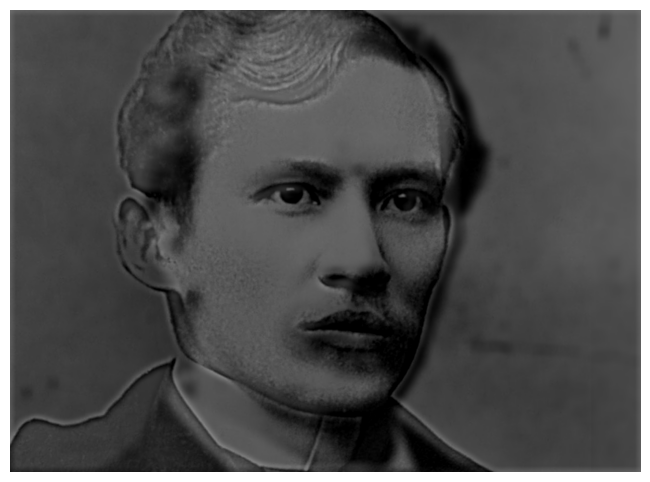

In [9]:
plt.figure(figsize=(15,6))
plt.axis('off')
plt.imshow(hybrid_image)

### Photos Comparison with the Hybrid Image

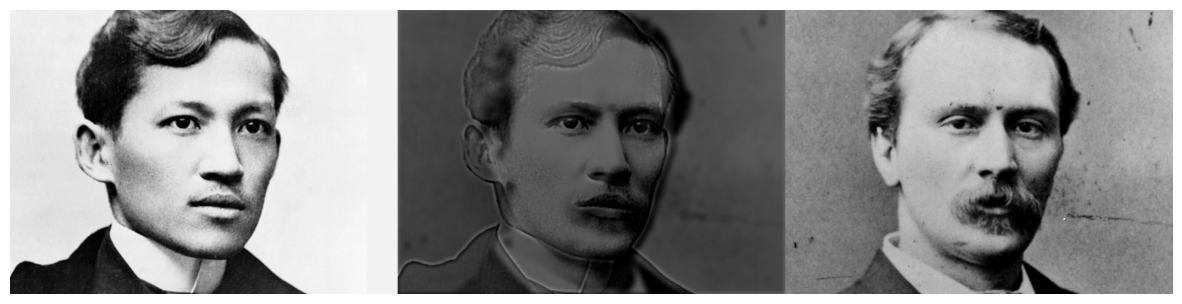

In [10]:
combine = cv.hconcat([rizal, hybrid_image, jack])
plt.figure(figsize=(15,5))
plt.axis('off')
plt.imshow(combine)